In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data)
%load_ext rpy2.ipython

#### Load the data
We load the preprocessed, trial data aligned to the response time. Trials are 4 seconds.

In [31]:
behavior = load_behavioral_data(min_RT = 0.2)

Include the distance from indifference for each subject. 

In [32]:
%%R -i behavior -o dist_indiff
library(lme4)
library(lmerTest)

# for each subject, run acccept ~ gain + loss
# and save the coefficients
slope <- c()
subs <- c()
for (i in unique(behavior$sub)) {
    sub_behavior = behavior[behavior$sub == i,]
    model = glm(accept ~ gain + loss, data = sub_behavior, family=binomial)
    slope <- c(slope, unname(coef(model)["loss"]) / unname(coef(model)["gain"]))
    subs <- c(subs, i)
}

dist_indiff <- data.frame(sub = subs, slope = slope)

In addition: There were 14 warnings (use warnings() to see them)


In [33]:
behavior = behavior.merge(dist_indiff, on = "sub")

In [34]:
behavior["dist_from_indiff"] = np.abs((behavior["gain"] + behavior["slope"] * behavior["loss"]) / np.sqrt(1 + behavior["slope"]**2))
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])

<Axes: xlabel='slope', ylabel='Count'>

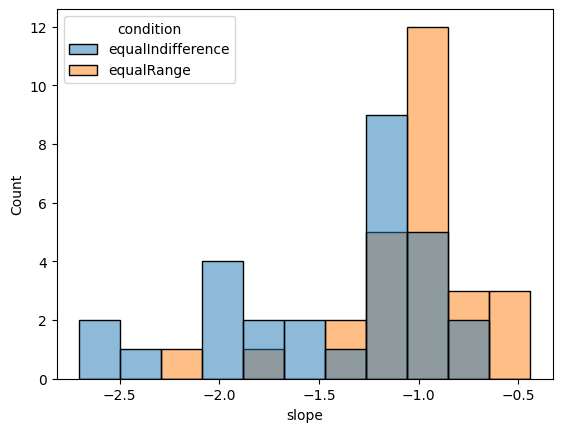

In [41]:
sns.histplot(data.groupby(["condition", "sub"])["slope"].mean().reset_index(), x = "slope", hue = "condition")

### Average every 0.5 seconds pupil

In [21]:
timebins = np.arange(0, 4, 0.25)
pupil_response = []
for timebin in timebins:
    decision_pupil = data.query(f"timebin > {timebin} & timebin < {timebin + 0.5}").groupby(["sub", "condition", "gain", "loss", "accept", "dist_indiff", "RT"])[["ps_preprocessed", "blink"]].mean().reset_index()
    decision_pupil["timebin"] = timebin
    pupil_response.append(decision_pupil)
pupil_response = pd.concat(pupil_response)

#### Modeling timebins of pupil size
We will model the pupil size as a function of the accept, blink, and condition. We want to observe the effect of the accept, gain, and loss on pupil size. Furthermore, we want to eliminate the effect of blink and condition

In [23]:
%%R -i pupil_response
library(mgcv)
library(lme4)
library(lmerTest)

In [24]:
%%R
# loop through timebins
timebins <- c()
coefficient_pvalues <- c()
coefficient_name <- c()
coefficient_estimate <- c()
condition_list <- c()
for (tb in unique(pupil_response$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model_indiff = lmer(ps_preprocessed ~ gain + loss + dist_indiff + blink + (1 | sub), data=pupil_response[pupil_response$timebin == tb & pupil_response$condition == 'equalIndifference', ])
    model_equal = lmer(ps_preprocessed ~ gain + loss + dist_indiff + blink + (1 | sub), data=pupil_response[pupil_response$timebin == tb & pupil_response$condition == 'equalRange', ])
    # save the coefficients and pvalues in a list
    fixed_effects <- summary(model_indiff)$coefficients
    # Loop through fixed effects
    for (i in 1:nrow(fixed_effects)) {
        effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
        estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
        p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
        coefficient_pvalues <- c(coefficient_pvalues, p_value)
        coefficient_name <- c(coefficient_name, effect_name)
        coefficient_estimate <- c(coefficient_estimate, estimate)
        timebins <- c(timebins, tb)
        condition_list <- c(condition_list, 'equalIndifference')
    }

    fixed_effects <- summary(model_equal)$coefficients
    for (i in 1:nrow(fixed_effects)) {
        effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
        estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
        p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
        coefficient_pvalues <- c(coefficient_pvalues, p_value)
        coefficient_name <- c(coefficient_name, effect_name)
        coefficient_estimate <- c(coefficient_estimate, estimate)
        timebins <- c(timebins, tb)
        condition_list <- c(condition_list, 'equalRange')
    }
}

In [25]:
%%R -o all_sub_pupil_coef
# put them into a dataframe
all_sub_pupil_coef <- data.frame(timebin = timebins, 
                            name = coefficient_name, 
                            estimate = coefficient_estimate, 
                            pvalue = coefficient_pvalues, 
                            condition = condition_list)

In [26]:
equalRange_rows = all_sub_pupil_coef["condition"] == 'equalRange'
equalIndifference_rows = all_sub_pupil_coef["condition"] == 'equalIndifference'

all_sub_pupil_coef["pvalue"] = stats.false_discovery_control(all_sub_pupil_coef['pvalue'].values, method = "by")

In [27]:
timebins = all_sub_pupil_coef['timebin'].unique()
names = ["gain", "loss", "dist_indiff"]

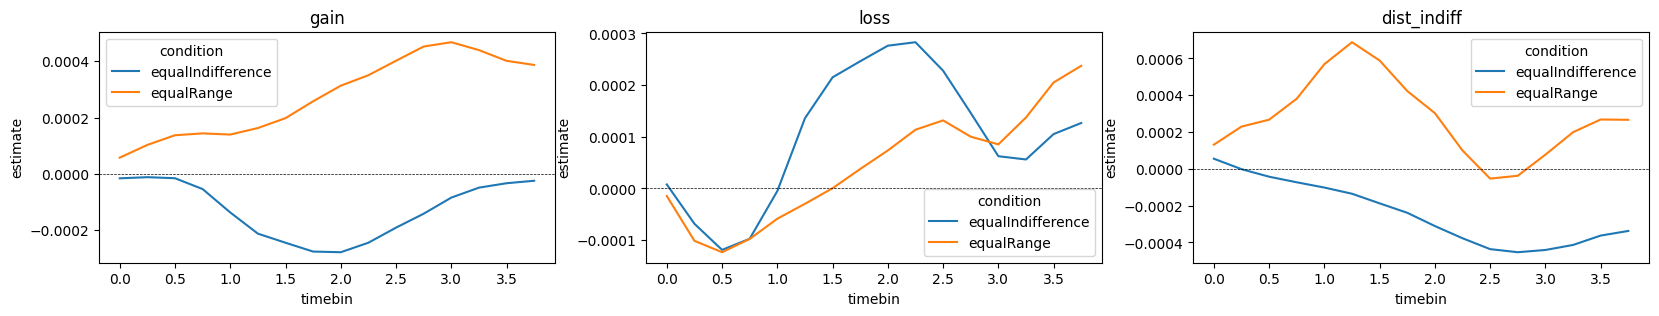

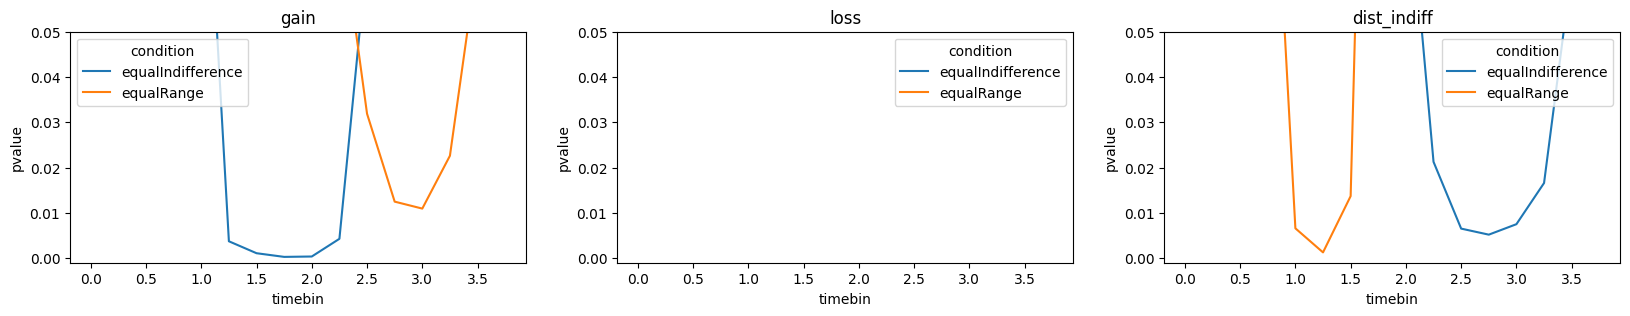

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for name, ax in zip(names, axs.flatten()):
    sns.lineplot(data=all_sub_pupil_coef.query(f"name == '{name}'"), x='timebin', y='estimate', hue = 'condition', ax=ax)
    # add a horizontal line at 0
    ax.axhline(0, ls="--", c="k", lw=0.5)
    ax.set_title(name)
    # ax.set_ylim(-0.5, 1.2)

fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for name, ax in zip(names, axs.flatten()):
    sns.lineplot(data=all_sub_pupil_coef.query(f"name == '{name}'"), x='timebin', y='pvalue', hue = 'condition', ax=ax)
    ax.set_title(name)
    ax.set_ylim(-0.001, 0.05)